# PLUMED wrapper in OpenPathSampling
#### Author: Alberto Pérez de Alba Ortíz

This ipython notebook exemplifies how to calculate PLUMED CVs in OPS. 

For further PLUMED details see: http://plumed.github.io/doc-master/user-doc/html/index.html

Special thanks to Gareth A. Tribello for facilitating the use of the PLUMED cython wrapper.

* G.A. Tribello, M. Bonomi, D. Branduardi, C. Camilloni, G. Bussi, PLUMED2: New feathers for an old bird, Comp. Phys. Comm. 185, 604 (2014); https://doi.org/10.1016/j.cpc.2013.09.018

## 1. Import OPS and PLUMED modules 

Import additional tools and do a clean-up.

In [1]:
import openpathsampling as paths
import openpathsampling.engines.openmm as peng_omm
import mdtraj as md
from openpathsampling import MDTrajFunctionCV

from openpathsampling.collectivevariables.plumed_wrapper import PLUMEDCV, PLUMEDInterface

import numpy as np
np.set_printoptions(precision=3, suppress=True, threshold=5)

import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.axes.titlepad = 20 

import os

root = os.listdir(".")
for item in root:
    if item.endswith(".log"):
        os.remove(item)
    if item.endswith(".nc"):
        os.remove(item)
    if item.endswith("out_path.pdb"):
        os.remove(item)      

## 2. Load a topology and a trajectory
Trajectory of alanine dipeptide (AMBER96) in water (TIP3P) from C7$_{eq}$ to $\alpha_R$

In [2]:
resources = "../../../openpathsampling/tests/test_data/"
topology = peng_omm.tools.topology_from_pdb(resources + "plumed_wrapper/AD_initial_frame.pdb")
trajectory = peng_omm.trajectory_from_mdtraj(md.load(resources + "ala_small_traj.pdb"))

## 3. Create a PLUMED interface

Upon initialization, a `PLUMEDInterface` requires an MDTraj topology and accepts additional PLUMED settings (`pathtoplumed`, `timestep, kbt, molinfo, logfile`).

The function `PLUMEDInterface.set(name, definition)` allows to run non-outputting commands (i.e., not CVs) in the PLUMED interface. In this syntax, `name` corresponds to a PLUMED label (mainly for virtual/group atoms) and `definition` contains the PLUMED keywords as they would be written in a PLUMED input file. Please note that some commands do not need a `name`, and that some others must be set before any other command (e.g., `UNITS`)

The function `PLUMEDInterface.get()` allows to consult the commands that have been run on a `PLUMEDInterface`.

In [3]:
plmd = PLUMEDInterface(topology, logfile="example_plumed.log")
plmd.set("", "UNITS LENGTH=nm")
plmd.set("zero", "FIXEDATOM AT=0,0,0")
plmd.get()

/Users/alberto/Software/openpathsampling/openpathsampling/collectivevariables/plumed_wrapper.py:259: UserWarning: Using currently sourced PLUMED from: /Users/alberto/opt/anaconda3/envs/reqs/lib/libplumedKernel.dylib
  plumed.sys.prefix + "/lib/libplumedKernel.dylib")


(('', 'UNITS LENGTH=nm'), ('zero', 'FIXEDATOM AT=0,0,0'))

## 4. Calculate a few basic CVs

The syntax is `cv = PLUMEDCV(name, PLUMEDInterface, definition)`, where `name` is the PLUMED label of the CV, and `definition` contains the PLUMED keywords as they would be written in a PLUMED input file.

In [4]:
dist = PLUMEDCV("dist", plmd, "DISTANCE ATOMS=5,7")
angl = PLUMEDCV("angl", plmd, "ANGLE ATOMS=5,7,9")
phi = PLUMEDCV("phi", plmd, "TORSION ATOMS=5,7,9,15")
psi = PLUMEDCV("psi", plmd, "TORSION ATOMS=7,9,15,17")

print("dist =\t", dist(trajectory))
print("angl =\t", angl(trajectory))
print("phi =\t", phi(trajectory))
print("psi =\t", psi(trajectory))

dist =	 [0.134 0.134 0.134 ... 0.133 0.134 0.133]
angl =	 [2.155 2.153 2.174 ... 2.148 2.133 2.18 ]
phi =	 [-1.429 -1.44  -1.426 ... -1.237 -1.227 -1.226]
psi =	 [-0.181 -0.21  -0.163 ... -0.228 -0.319 -0.331]


## 5. Calculate a CV based on virtual/group atoms

Group atoms, same as other non-outputting commands, are declared via the `PLUMEDInterface.set(name, definition)` function. 

The CV must be declared using the same `PLUMEDInterface` that contains the previously defined groups.

In [5]:
plmd.set("group", "GROUP ATOMS=5,7,9,15")
phi_group = PLUMEDCV("phi_group", plmd, "TORSION ATOMS=group")

print("Are both torsions equal?\t", (phi_group(trajectory) == phi(trajectory)).all())

Are both torsions equal?	 True


## 6. Calculate a function of previously defined CVs

The function of CVs must be declared using the same `PLUMEDInterface` that contains the previously defined CVs.

In [6]:
comb = PLUMEDCV("comb", plmd, "COMBINE ARG=phi,psi PERIODIC=-pi,pi")

print('phi + psi =\t', comb(trajectory))

phi + psi =	 [-1.61  -1.65  -1.589 ... -1.465 -1.546 -1.557]


## 7. Calculate an RMSD
Please note that RMSD and similar CVs require a reference PDB file in Angstroms with OCCUPANCY and BETA columns.
For more details, see: http://plumed.github.io/doc-master/user-doc/html/_r_m_s_d.html

In [7]:
rmsd=PLUMEDCV("rmsd", plmd, "RMSD REFERENCE=" + resources + "plumed_wrapper/AD_plumed_rmsd.pdb TYPE=OPTIMAL")

print('rmsd =\t', rmsd(trajectory))

rmsd =	 [0.    0.003 0.006 ... 0.03  0.036 0.042]


## 8. Calculate a CV with components

This requires adding the keyword `components=["c1","c2","c3",...]` to the `PLUMEDCV` declaration.

In [8]:
comp = PLUMEDCV("comp", plmd, "DISTANCE ATOMS=5,7 COMPONENTS", components=["x","y","z"])
print('distance components =\n', comp(trajectory))
print('Are the components consistent with the distance?',\
((comp(trajectory)[:, 0]**2 + comp(trajectory)[:, 1]**2 + comp(trajectory)[:, 2]**2)**0.5\
 == dist(trajectory)).all())


distance components =
 [[ 0.068 -0.114 -0.012]
 [ 0.068 -0.115 -0.014]
 [ 0.069 -0.114 -0.012]
 ...
 [ 0.057 -0.12  -0.009]
 [ 0.054 -0.123 -0.01 ]
 [ 0.052 -0.121 -0.015]]
Are the components consistent with the distance? True


## 9. Save and load a PLUMED interface with some commands

Please note this only saves the commands run by `PLUMEDInterface.set(name, definition)`. To save CVs, see the next example.

In [9]:
store = paths.Storage('plmd.nc', 'w')
store.save(trajectory[:2])
store.tags['a']=plmd
store.sync()
store.close()

store2 = paths.Storage('plmd.nc', 'r')
plmd2 = store2.tags['a']
store2.close()

print('Saved commands:\t', plmd.get())
print('Are the saved and loaded PLUMED interfaces consistent?\t', plmd.get() == plmd2.get())

Saved commands:	 (('', 'UNITS LENGTH=nm'), ('zero', 'FIXEDATOM AT=0,0,0'), ('group', 'GROUP ATOMS=5,7,9,15'))
Are the saved and loaded PLUMED interfaces consistent?	 True


## 10. Save and load a PLUMED CV

This saves a particular CV, and the corresponding `PLUMEDInterface` with the commands run by `PLUMEDInterface.set(name, definition)`.

In [10]:
CVstore = paths.Storage('phi_group.nc', 'w')
CVstore.save(trajectory[:2])
CVstore.save(phi_group)
CVstore.sync()
CVstore.close()

CVstore2 = paths.Storage('phi_group.nc', 'r')
phi_group2 = CVstore2.cvs[phi_group.name]
CVstore2.close()

print('Are the saved and loaded PLUMED CVs consistent?\t', (phi_group(trajectory) == phi_group2(trajectory)).all())

Are the saved and loaded PLUMED CVs consistent?	 True


## 11. Optimize an adaptive path-CV

Path-CVs allow to project configurations in  a high-dimensional CV-space onto a 1D progress parameter along a curve between two stable states. The curve can be optimized on-the-fly based either on the free energy gradient or the average CV density. This enables to perform enhanced sampling simulations on complex systems, without limitations on the number of CVs. For example, we can run metadynamics on the progress parameter, i.e, path-metadynamics (PMD). Additionally, we can optimize an adaptive path-CV a posteriori using trajectories from a TPS ensemble. Here, we show a minimal example of the procedure for a single trajectory.

For more details on the adaptive path-CV and PMD see: 

* G. Díaz Leines, and B. Ensing., Phys. Rev. Lett. 109, 020601 (2012); https://doi.org/10.1103/PhysRevLett.109.020601
* A. Pérez de Alba Ortíz, A. Tiwari, R. C. Puthenkalathil, and B. Ensing, J. Chem. Phys. 149, 072320 (2018); https://doi.org/10.1063/1.5027392
 
For more details on PLUMED keywords and options, see: http://plumed.github.io/doc-master/user-doc/html/_a_d_a_p_t_i_v_e__p_a_t_h.html

### 11.1 Calculate the components of an adaptive path-CV

Note: the `ADAPTIVE_PATH` requires an initial guess path (`REFERENCE`). The file `in_path.pdb` provides this based on a linear interpolation between the first and last points of the trajectory.

The `ADAPTIVE_PATH` is optimized at every timestep based on the average CV density and returns two components:
* `gspath`: the progress along the path for the current configuration in CV-space obtained after projecting it onto the path.
* `gzpath`: the distance from the path to the current configuration in CV-space.

Notice that the value of `gzpath` is zero at the beginning and at the end of the trajectory, while the value of `gspath` evolves form zero to one. This is because the first and last configurations of the trajectory were taken as initial and final path nodes.

This requires to load a C7$_{eq}$ to $\alpha_R$ trajectory from storage. The path definition expects a transition with an incremental $\phi$ value, i.e., with no periodic crossing from $-\pi$ to $\pi$. Such a trajectory is generated in: 

https://github.com/openpathsampling/openpathsampling/blob/master/examples/alanine_dipeptide_tps/AD_tps_1_trajectory.ipynb

In [12]:
storage = paths.Storage("./AD_trajectory.nc", "r")
full_trajectory = storage.trajectories[0]

pcv = PLUMEDCV("pcv",
                plmd,
                "ADAPTIVE_PATH " 
                "TYPE=EUCLIDEAN REFERENCE=in_path.pdb FIXED=1,50 UPDATE=1 WSTRIDE=1 HALFLIFE=100 WFILE=out_path.pdb",
                components=["gspath","gzpath"])

print('gspath, gzpath =\n', pcv(full_trajectory))

gspath, gzpath =
 [[0.    0.   ]
 [0.051 0.288]
 [0.125 0.229]
 ...
 [0.887 0.061]
 [0.889 0.185]
 [1.    0.   ]]


### 11.2 Analyze the optimization of an adaptive path-CV

The `ADAPTIVE_PATH` is optimized by following the average CV density. We read the path output files and plot the path optimization steps.

In [13]:
ncv = 2
nnode = 50

path = []
with open("in_path.pdb","r") as f:
    lines=f.readlines()
    for line in lines:
        if 'phi=' in line:
            words = line.split()
            for word in words:
                if 'phi=' in word:
                    node_phi = word.split('=')[1]
                if 'psi=' in word:
                    node_psi = word.split('=')[1]
            path.append((node_phi,node_psi))
            
with open("out_path.pdb","r") as f:
    lines=f.readlines()
    for line in lines:
        if 'phi=' in line:
            words = line.split()
            for word in words:
                if 'phi=' in word:
                    node_phi = word.split('=')[1]
                if 'psi=' in word:
                    node_psi = word.split('=')[1]
            path.append((node_phi,node_psi))

path = np.asarray(path,dtype=np.float64)
path = np.reshape(path,(int(len(path)/nnode),nnode,ncv)) 

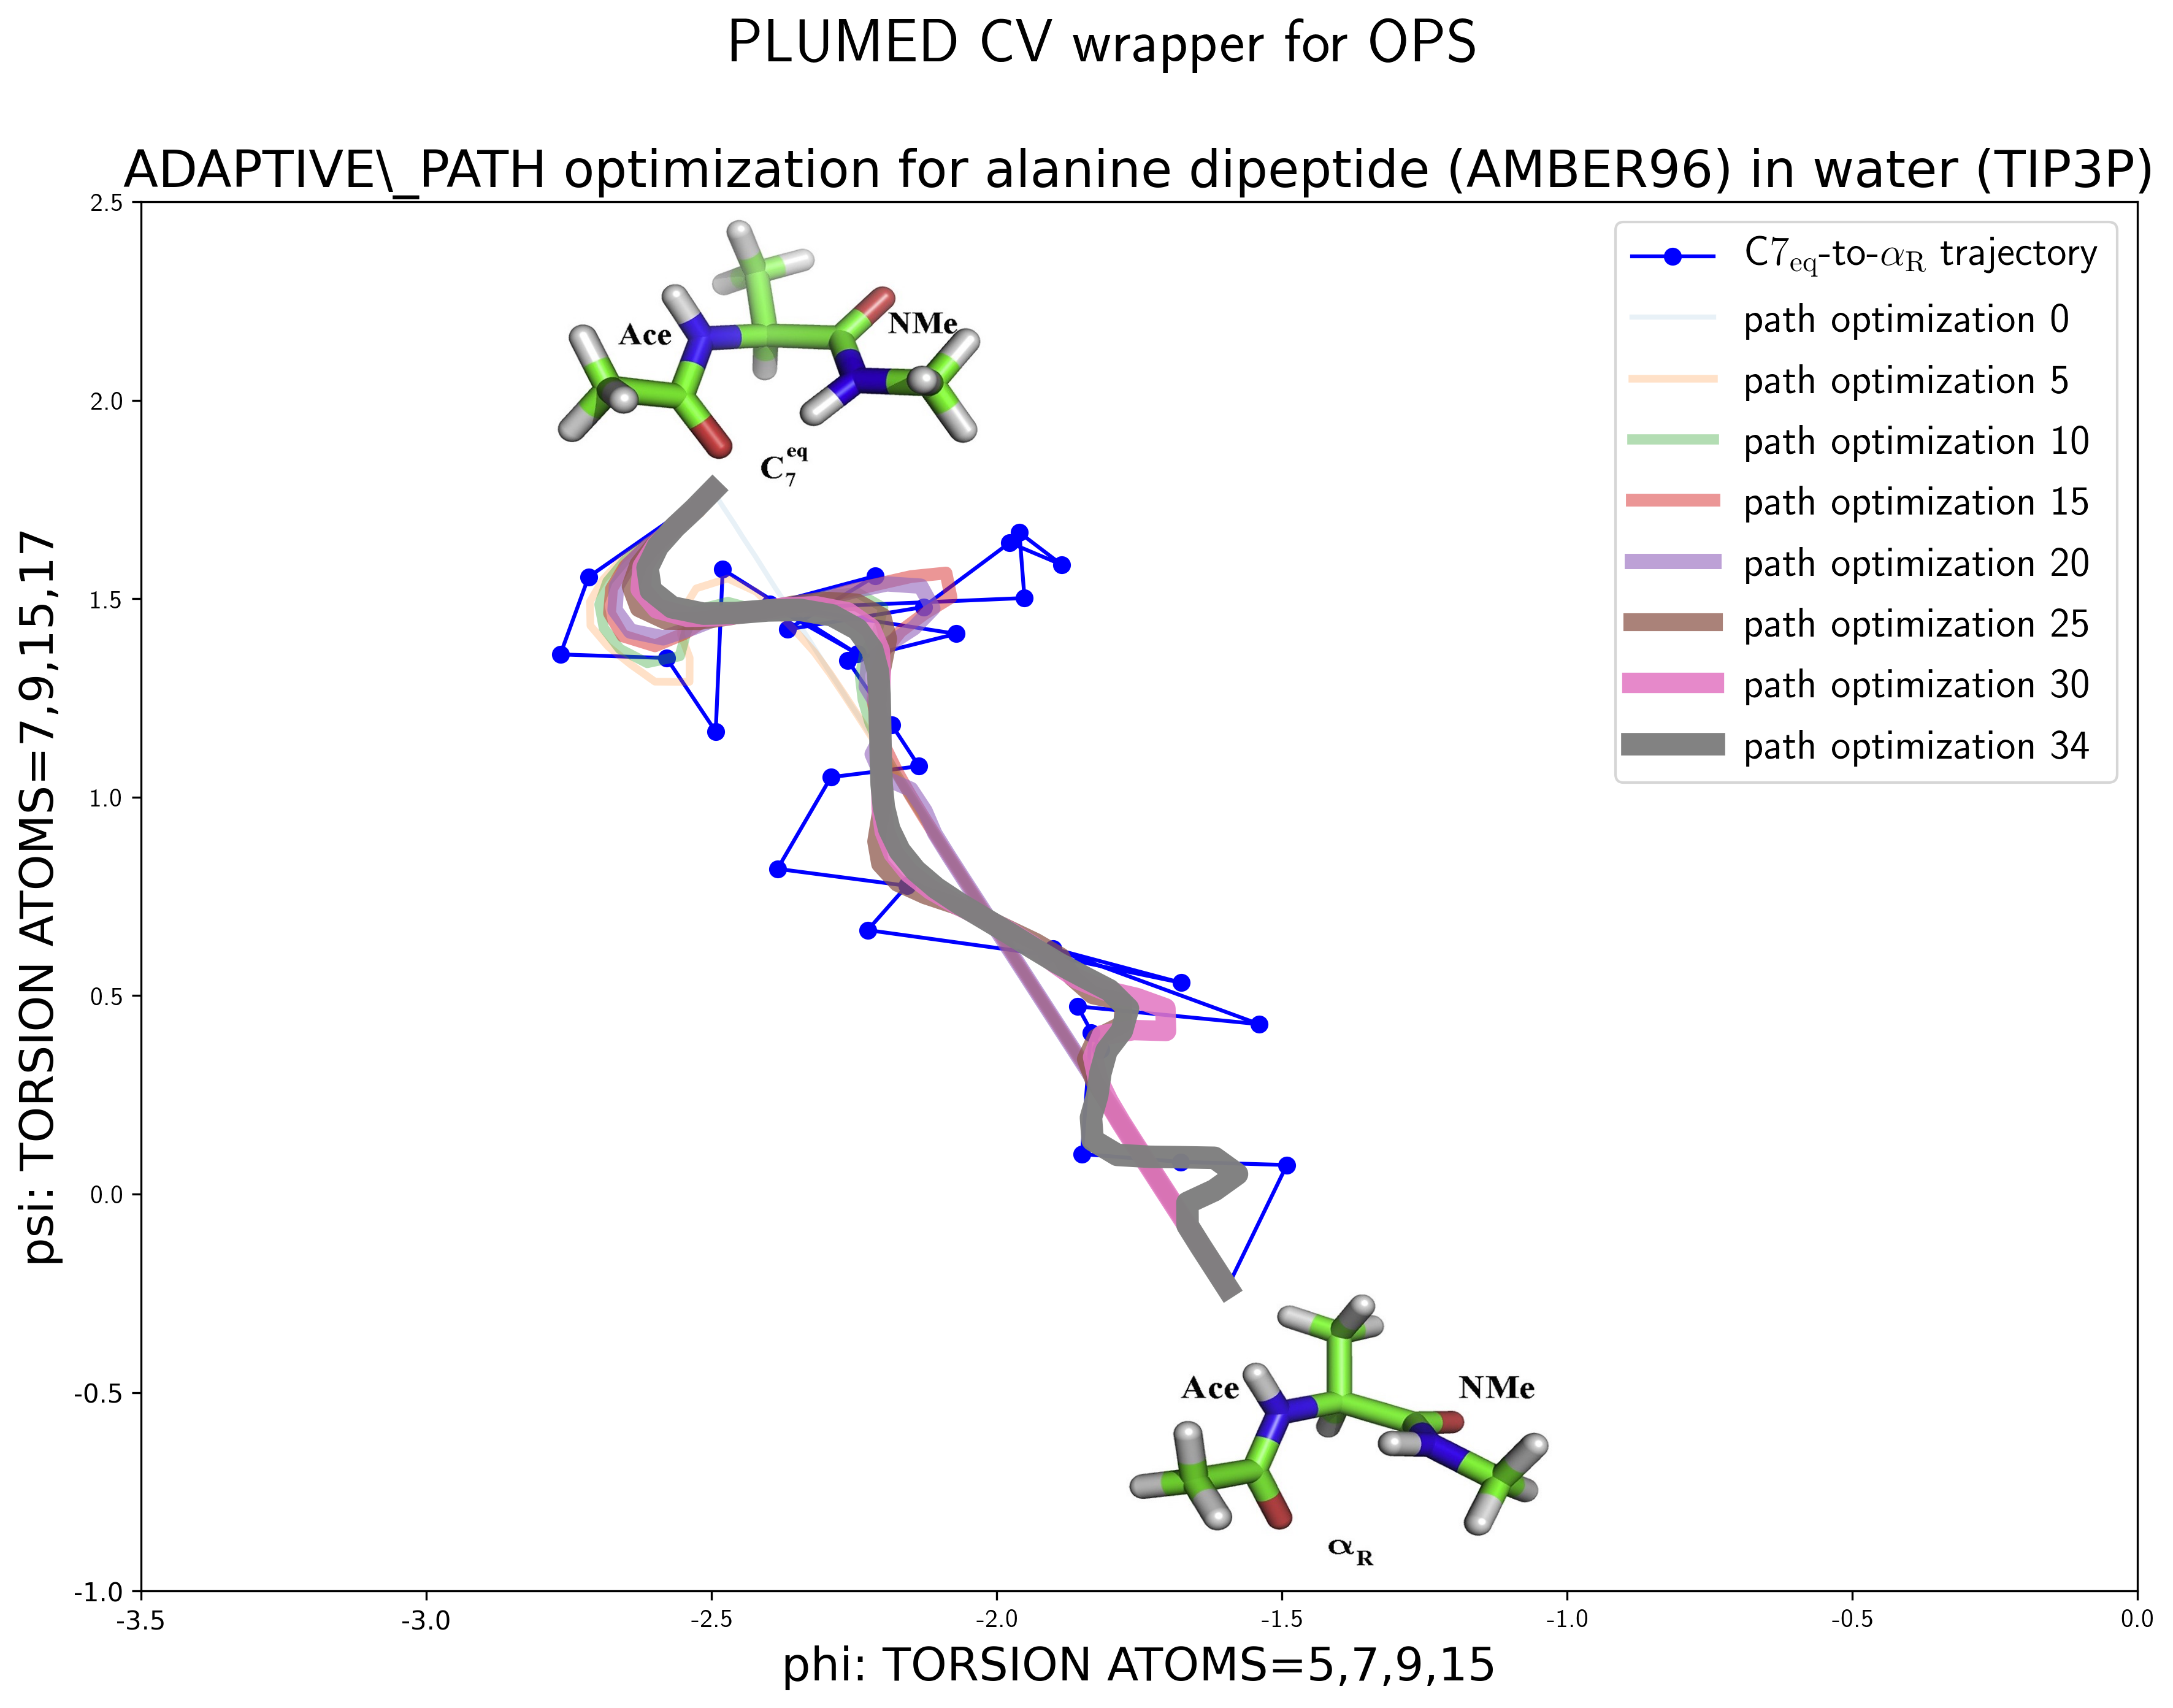

In [14]:
fig, ax = plt.subplots(figsize=(14, 10))

ax.set_xlim(-3.5, 0.0)
ax.set_ylim(-1.0, 2.5)

plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

fig.suptitle('PLUMED CV wrapper for OPS', fontsize=24)
ax.set_title('ADAPTIVE\_PATH optimization for alanine dipeptide (AMBER96) in water (TIP3P)', fontsize=20)
ax.set_xlabel('phi: TORSION ATOMS=5,7,9,15', fontsize=18)
ax.set_ylabel('psi: TORSION ATOMS=7,9,15,17', fontsize=18)

ax.plot(phi(full_trajectory), psi(full_trajectory), 'o-', color='b', label=r'C$7_{\rm eq}$-to-$\alpha_{\rm R}$ trajectory')

for optstep in list(range(0,len(path),5)) + [len(path)-1]:
    ax.plot(path[optstep,:,0],path[optstep,:,1], '-', label='path optimization ' + str(optstep),
             linewidth=(0.2 * optstep + 2.0), alpha=( (0.9/len(path))* optstep + 0.1))

ax.legend(fontsize=16)

xcoord = -2.4
ycoord = 2.1
halflen = 0.4
c7 = img.imread('AD_C7eq.png')
ax.imshow(c7, aspect='auto', extent=(xcoord-halflen, xcoord+halflen, ycoord-halflen, ycoord+halflen), zorder=-1)

xcoord = -1.4
ycoord = -0.6
halflen = 0.4
ar = img.imread('AD_aR.png')
ax.imshow(ar, aspect='auto', extent=(xcoord-halflen, xcoord+halflen, ycoord-halflen, ycoord+halflen), zorder=-1)

plt.show()

Alanine dipeptide pictorial representations taken from:

* J. Rubio-Martinez, M. Santos Tomas, J.J. Perez, J. Mol. Graph. Model. 78, 118, (2017); https://doi.org/10.1016/j.jmgm.2017.10.005

By recursively using the optimized path as new initial guess, one can improve the optimization after some iterations. By iterating over the trajectories of a TPS ensemble, an average transition path can be localized.